[edit base on `roylevy`](https://www.kaggle.com/code/roylevy/pamap2-roy-yuval?rvi=1)

### In this notebook we are going to fucus on the *PAMAP2* dataset.
### The dataset, provided in: https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring<br> consists on measurements that were monitored on 9 subject while performing certain phsical activities over time such as: running, standing or cycle.<br>The measurements were colected by various of wireless sensors that the subjects wore on their body. 
### Our goal for this report is to build a model that can predict the given task a subject is performing based on a given measurements.

---

# Loading the Data
We will start first by loading and preparing our data
---

In [1]:
# import and all essentials for the report

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

import os
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
scaler = StandardScaler()

In [2]:
# this section contains the filenames of the data and columns mappings

inp_prefix = "/kaggle/input/"

list_of_files = ['pamap2/subject101.dat',
                 'pamap2/subject102.dat',
                 'pamap2/subject103.dat',
                 'pamap2/subject104.dat',
                 'pamap2/subject105.dat',
                 'pamap2/subject106.dat',
                 'pamap2/subject107.dat',
                 'pamap2/subject108.dat',
                 'pamap2/subject109.dat' ]

subjectID = [1,2,3,4,5,6,7,8,9]

activityIDdict = {0: 'transient',
              1: 'lying',
              2: 'sitting',
              3: 'standing',
              4: 'walking',
              5: 'running',
              6: 'cycling',
              7: 'Nordic_walking',
              9: 'watching_TV',
              10: 'computer_work',
              11: 'car driving',
              12: 'ascending_stairs',
              13: 'descending_stairs',
              16: 'vacuum_cleaning',
              17: 'ironing',
              18: 'folding_laundry',
              19: 'house_cleaning',
              20: 'playing_soccer',
              24: 'rope_jumping' }

# 基本列
colNames = ["timestamp", "activityID","heartrate"]

# 三个位置的IMU
IMUhand = ['handTemperature', 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature', 
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

# 所有列
columns = colNames + IMUhand + IMUchest + IMUankle

In [3]:
# loading the data into pandas DataFrame

def process_user(file):
    data_pamap2 = pd.DataFrame()
    subject = pd.read_table(file, header=None, sep='\s+')
    subject.columns = columns
    subject['subject_id'] = int(file[-5])  # 将列值更新为 uid, 1~9
    subject.reset_index(drop=True, inplace=True)
    subject_dat = subject
    user = int(file[-5])
    return subject_dat, user


Before we start to examine the loaded data we will the start by presanting an overview on the data.<br> if you want a full overview you can check out the provided PDF's.

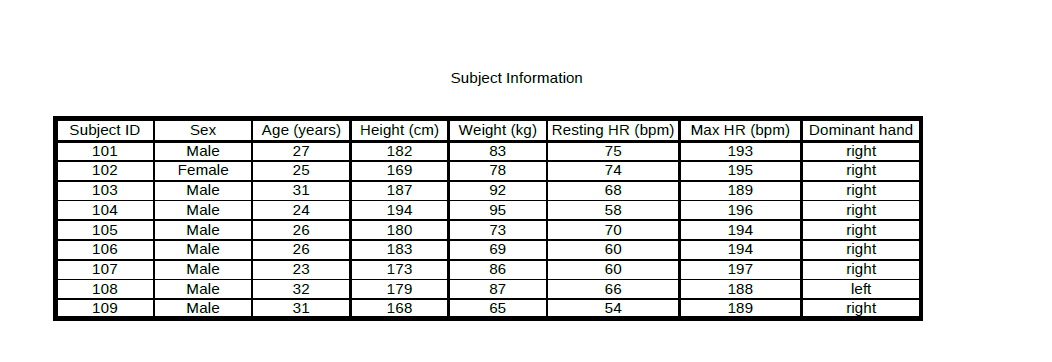

We can see clearly from the picture above that the age of the subjects varies between 24-32.<br> also note that there are 8 males and only 1 female tested.

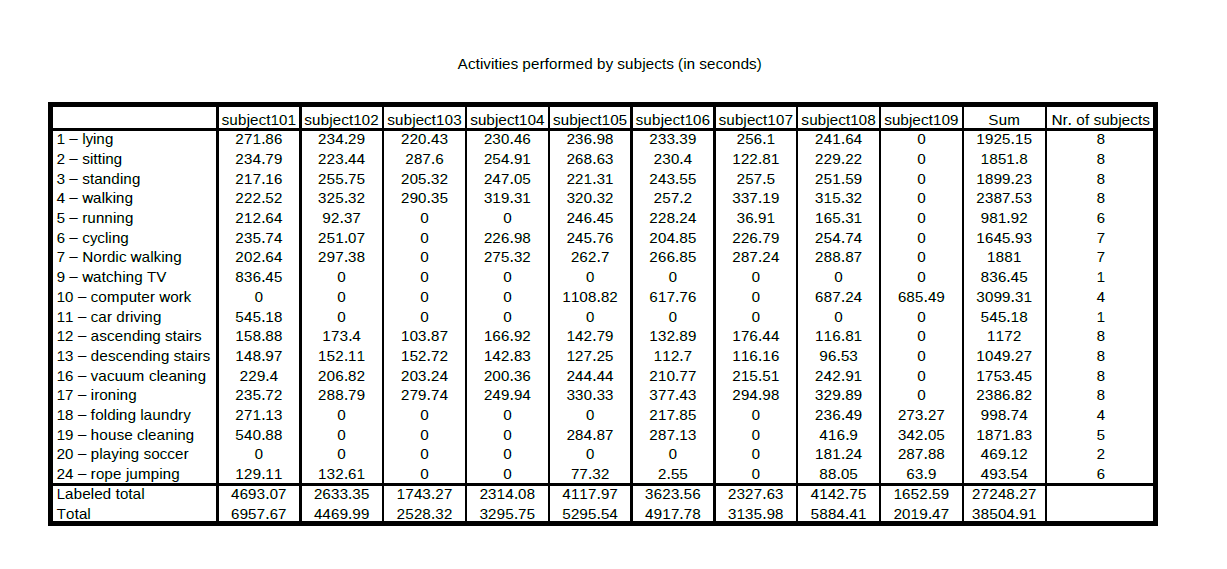

As it seen from the picture above, most of the data is going be balanced,<br>i.e. most of the task were performed in the same amount of time and with mostly even distribution across the range of subjects.<br><br>Note that **subject 109** performed the least amount of activities, this is a notion we need to refer while testing the model's, we don't want only him to represant our testing data.

## Data Cleaning
---

## 清除活动转换数据
It can be seen from the sample of the loaded data that some **data cleaning** is required.
For example the activityID 0 must be removed completely from the dataset because it is represanting a transient state(see the readme.pdf for more information).

act0对应活动间的转换，需要被清除。

## NaN值替换
From the given file **PerformedActivitiesSummary** we can see that few of the data is missing, due to wireless disconnections for example.<br>
We chose also to remove the body orientation, because it seems to us irrelavnat and will take the model more time to train.<br><br> The easiest way to remove the NaN values is to use interpolation, we will start by removing the irrelavant values and then interpolate between the unkown values.
<br><br>
使用插值法替换NaN值<br>
经过插值法后仍存在的NaN值存在于开头部分，直接删除即可


## 多模态传感器选用
使用多模态传感器，这里根据数据集推荐选用了精度更高的16g加速度计<br>
```python
# 三个位置的IMU
IMUhand = [ 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = [
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = [
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']
```



## 标签映射
1-->0<br>
2-->1<br>
3-->2<br>
4-->3<br>
5-->4<br>
6-->5<br>
7-->6<br>
9-->7<br>
10-->8<br>
11-->9<br>
12-->10<br>
13-->11<br>
16-->12<br>
17-->13<br>
18-->14<br>
19-->15<br>
20-->16<br>
24-->17<br>

In [4]:
def clean_data(data):
    # removing data with transient activity  去除活动转换的数据
    data = data.drop(data[data['activityID']==0].index)
    
    # remove non-numeric data cells  去除非数值的列
    data = data.apply(pd.to_numeric, errors = 'coerce')
    
    # removing NaN values using iterpolation  通过插值法去除NaN值
    data_clean = data.interpolate()
    
    # simply drop the still NaN row
    data_clean = data_clean.dropna(axis=0)
    
    return data_clean

label_mapping = {
    "1":"0",
    "2":"1",
    "3":"2",
    "4":"3",
    "5":"4",
    "6":"5",
    "7":"6",
    "9":"7",
    "10":"8",
    "11":"9",
    "12":"10",
    "13":"11",
    "16":"12",
    "17":"13",
    "18":"14",
    "19":"15",
    "20":"16",
    "24":"17",
}


As we can see there are still 4 more values of NaN for the heart rate for the first subject,<br>this is due the notion that the first 4 values were NaN so the interpolation uses these values.<br><br>As it can be seen the heart rate for this subject is 100.0 for at least 10 more timelapses, so we will assumes that the 4 values are also 100.0 since heart rate don't change rapidly, also note that the activity performed by the subject is 'lying' which makes our assumption more realistic.

## 进一步处理：每种活动数据的归一化、降采样、滑动窗口

In [5]:
def sliding_window(time_series, width, step, order='F'):
    w = np.hstack([time_series[i:1 + i - width or None:step] for i in range(0, width)])
    result = w.reshape((int(len(w) / width), width), order='F')
    if order == 'F':
        return result
    else:
        return np.ascontiguousarray(result)

def calc_normalization(data):
    num_instances, num_time_steps, num_features = data.shape
    data = np.reshape(data, (num_instances, -1))
    scaler.fit(data)
#     mean, std = (np.array([np.mean(x) for x in X_train], dtype=np.float32), np.array([np.std(x) for x in X_train], dtype=np.float32))
    return scaler
    
def apply_normalization(data, scaler):
#     scaler = StandardScaler()
    num_instances, num_time_steps, num_features = data.shape
    data = np.reshape(data, (num_instances, -1))
    norm_data = scaler.transform(data)
#     debug_here()
#     data = (data - mean) / (std + 1e-5)
    norm_data[np.isnan(norm_data)] = 0
    norm_data = np.reshape(norm_data, (num_instances, num_time_steps, num_features))
    return norm_data

def get_useChannels():
    IMUhand = [ 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
        'handMagne1', 'handMagne2', 'handMagne3',
           'handGyro1', 'handGyro2', 'handGyro3', ]
#            'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

    IMUchest = [
               'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
        'chestMagne1', 'chestMagne2', 'chestMagne3',
               'chestGyro1', 'chestGyro2', 'chestGyro3', ]
#                'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

    IMUankle = [
               'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
        'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
               'ankleGyro1', 'ankleGyro2', 'ankleGyro3', ]
#                'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']
    
    return IMUhand + IMUchest + IMUankle

## 进一步处理3：生成数据，划分训练数据集并保存
data len   : 200<br>
overlap    : 50%<br>
channel num: 27<br>
sensor num : 9<br>
train-test : 3-7<br>
normalize  : true<br>

In [6]:
def PAMAP2_data_generator(model_dat, user_index):
    seq_length = 200  # 数据长度 follow SALIENCE's setting
    shifting_step = 100  # overlap=0.5
    channel_nums = 3*3*3  # 各个模态的通道数 3 * IMU: (acc16, gyro, mag) * 3 channels
    
    # use specific columns
    dat_refined = model_dat.drop(columns=[
        "timestamp",
        "subject_id", 
        "heartrate",
        'handTemperature', 
        'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
        'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
        'chestTemperature', 
        'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
        'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
        'ankleTemperature', 
        'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
        'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'
    ])
#     print(f"cleaned dat shape: {dat_refined.shape}")  # [N, 27+1]
    
    user_data, user_labels = [], []
    # 用户label处理
    for act_id, act_data in dat_refined.groupby('activityID'):
        sample_cnt = int((act_data.shape[0]-seq_length)//shifting_step + 1)
        if sample_cnt < 2:
            print(f"user {user_index} has only {act_data.shape[0]} samplings, drop\n")
            continue
        data_shape = (sample_cnt, seq_length, channel_nums)  # (N, 200, 27)
        act_sliced_data = np.empty(data_shape)  
        channl_idx = 0
        for channel_name in get_useChannels():
            channel_data = act_data[channel_name]
            act_sliced_data[:,:,channl_idx] = sliding_window(channel_data.values, seq_length, shifting_step, 'T')
            channl_idx += 1
            
        # append label data 
        user_data.append(act_sliced_data)
        # gen labels
        class_labels = np.empty(act_sliced_data.shape[0])
        actual_label = label_mapping[str(act_id)]
        class_labels.fill(actual_label)
        user_labels.append(class_labels.astype(int))
        
    # data and labels for each users 
    array_user_data= np.concatenate(user_data, axis=0)
    array_user_labels= np.concatenate(user_labels, axis=0)
    print(user_index, array_user_data.shape, array_user_labels.shape)
    
    # Stratified train, validation, test split of the data 
    X_train, X_test, y_train, y_test = train_test_split(array_user_data, array_user_labels,  stratify=array_user_labels,  test_size=0.3,random_state=1)
    # print(X_train.shape)
    # print(y_train.shape)

    # Data normalization 
    # Calculate mean and standard deviation based on train
    scaler = calc_normalization(X_train)

    # Apply normalization 
    X_train = apply_normalization(X_train,scaler)
#         X_val = apply_normalization(X_val,scaler)
    X_test = apply_normalization(X_test,scaler)
    
    
    print(f"user: {user}")
    print(f"train data: {X_train.shape}, train label: {y_train.shape}")
    print(f"test data: {X_test.shape}, test label: {y_test.shape}\n")
    
    # prepare samples
    train_data = {'samples':X_train, 'labels':y_train}
#         val_data   = {'samples':X_val, 'labels':y_val}
    test_data  = {'samples':X_test, 'labels':y_test}

    os.makedirs(f'/kaggle/working/PAMAP2_data', exist_ok=True)
    torch.save(train_data, f'/kaggle/working/PAMAP2_data/train_{user_index}.pt')
    # torch.save(val_data,  f'HHAR_user_data/val_{user_name}.pt')
    torch.save(test_data, f'/kaggle/working/PAMAP2_data/test_{user_index}.pt')
    return
        
        
        
        
    
    

In [ ]:
# get user data
for file in list_of_files:
    # load raw data
    file = inp_prefix + file
    user_data, user = process_user(file)

    # get cleaned user data
    data_clean = clean_data(user_data)

    # show
    # display(data_clean.head(15))
    # print(data_clean.isnull().sum())
    
    # gen samples
    PAMAP2_data_generator(data_clean, user)